In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xarray
import time
import matplotlib.patches as patches
import glob

import matplotlib.colors as mcolors

from netCDF4 import Dataset
from scipy import stats

from matplotlib.animation import FuncAnimation

import geopandas as gpd
import geocube
from geocube.api.core import make_geocube
## estimate of pressure levels from the hybrid coordinate:
## lev0=975, 5=925, 8=850, 12=700, 17=500,  19=400, 21=300, 24=200, 29=100

ERROR 1: PROJ: proj_create_from_database: Open of /ocean/projects/atm200007p/xjliu/miniconda3/envs/geocube_env/share/proj failed


### First, load the lats, lons, and levs used for plotting later.

In [2]:
### Plot the height vs. time sections of potential temperature
import xarray
path = '/ocean/projects/ees210014p/xjliu/Amazon_exp/'
file = path+'Amazon961x801_201509_201602/wrfinput_d01'
with xarray.open_dataset(file,decode_times=False,
                         mask_and_scale='True') as ds1:
    lats=ds1['XLAT'][0,:,0]
    lons=ds1['XLONG'][0,0,:]
    lu1=ds1['LU_INDEX'][0,:,:]

### Check whether LUindex is changed correctly

<xarray.DataArray 'LU_INDEX' (west_east: 100)>
array([17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17.,
       17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17.,
       17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 17., 16., 16., 16.,
       16., 16., 16., 16., 16.,  7.,  7.,  7.,  7., 10.,  7., 10.,  7.,  7.,
        7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7.,  7., 10., 10.,  7.,
       10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10., 10.,
        7.,  7., 10.,  7., 10., 10., 10., 10.,  9., 10., 10., 10., 10., 10.,
        2.,  2.], dtype=float32)
Coordinates:
    XLAT     (west_east) float32 ...
    XLONG    (west_east) float32 ...
Dimensions without coordinates: west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  LAND USE CATEGORY
    units:        
    stagger:      
    coordinates:  XLONG XLAT XTIME


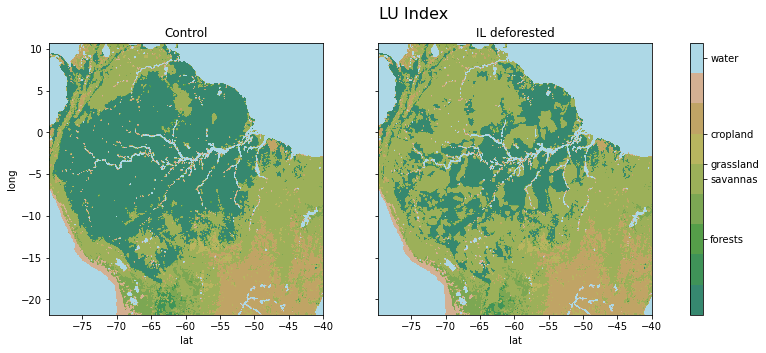

In [18]:
file0 = path+'Amazon961x801_200809_200902/wrfinput_d01'
with xarray.open_dataset(file0,decode_times=False,
                         mask_and_scale='True') as ds0:
    lu0=ds0['LU_INDEX'][0,:,:]

file1 = path+'Amazon961x801_200809_200902_ILgrassland/wrfinput_d01'
with xarray.open_dataset(file1,decode_times=False,
                         mask_and_scale='True') as ds1:
    lu1=ds1['LU_INDEX'][0,:,:]

### generate a new cmap
cmap = plt.get_cmap('gist_earth')
colors = cmap(np.linspace(0.3, 0.89, 100))
new_cmap = mcolors.LinearSegmentedColormap.from_list('test',colors)
new_cmap.set_over('lightblue')
############

fig,axes = plt.subplots(1,2,figsize=(13.5,5),sharex=True,sharey=True)
axes = axes.ravel()  
im=axes[0].contourf(lons,lats,lu0,cmap=new_cmap,vmax=16)  # ctrl luindex
axes[1].contourf(lons,lats,lu1,cmap=new_cmap,vmax=16)     # ILdeforeste luindex
axes[0].set_title('Control')
axes[1].set_title('IL deforested')
axes[0].set_xlabel('lat')
axes[1].set_xlabel('lat')
axes[0].set_ylabel('long')
plt.suptitle('LU Index',fontsize=16)
cbar = fig.colorbar(im,ax=axes, ticks = [5,9,10,12,17])
cbar.ax.set_yticklabels(['forests', 'savannas','grassland','cropland','water'])  # vertically oriented colorbar

print(lu1[300,:100])

# Precipitation plot

## 1. 6-month accumulated precipitation

### Mean precipitation

ok
ok


Text(0, 0.5, 'longitude')

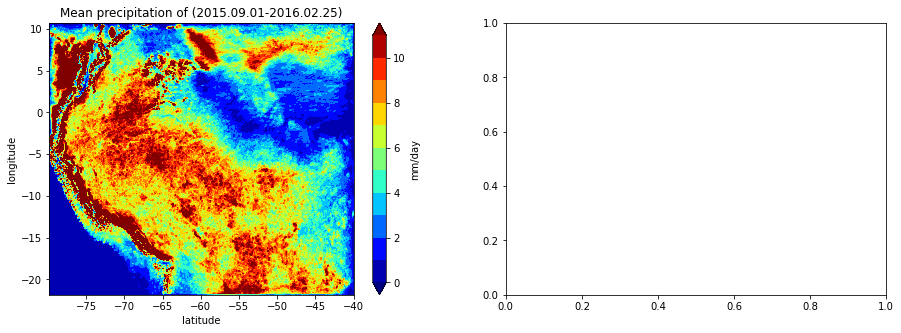

In [82]:
path = '/ocean/projects/ees210014p/xjliu/Amazon_exp/'
with xarray.open_dataset(path+'Amazon961x801_201509_201602/energyflux_d01_2016-02-28_00:00:00',decode_times=False,
                         mask_and_scale='True') as ds0:
    print('ok')

with xarray.open_dataset(path+'Amazon961x801_201509_201602_ILgrassland/energyflux_d01_2016-02-28_00:00:00',decode_times=False,
                         mask_and_scale='True') as ds1:
    print('ok')
    
fig, axs = plt.subplots(1,2,figsize=(15,5))
im=axs[0].contourf(lons,lats,ds0['RAINNC'][-1,:,:]/178,cmap='jet',
               levels=np.arange(0,12,1),extend='both')
fig.colorbar(im,ax=axs[0],label='mm/day')
axs[0].set_title('Mean precipitation of (2015.09.01-2016.02.25)')
#axs[0].contour(lons,lats,lu1-lu0,levels=[1])
#axs[0].contourf(lons,lats,IL_sel,hatches='+',alpha=0.1)

axs[0].set_xlabel('latitude')
axs[0].set_ylabel('longitude')


#### load in the Indigenous lands information for use in plotting

In [5]:
directory = '/ocean/projects/ees210014p/xjliu/DATA/landuse/'
shapefile = 'Raisg/Tis_2020/Tis_TerritoriosIndigenas.shp'  
IL1 = gpd.read_file(directory+shapefile) # read into a GeoDataFrame
IL_big = IL1[IL1.area_sig_h>1.6e5]  # select only the big domain
## rasterize data
IL_big['value']=1
IL1['value']=1
out_grid = make_geocube(IL_big,resolution=(0.04,-0.04),measurements=['value'],fill=-9999)
da_grib = xarray.where(out_grid.value<-1999.0, np.nan, out_grid.value)

with xarray.open_dataset(path+'Amazon961x801_200809_200902/wrfinput_d01_20080901',decode_times=False) as ds:
    print('ok')
lats = ds['XLAT'][0,:,:]
lons = ds['XLONG'][0,:,:]

IL_sel = da_grib.sel(y=lats[:,0],x=lons[0,:],method='nearest')
IL_sel.shape

/ocean/projects/atm200007p/xjliu/miniconda3/envs/geocube_env/lib/python3.10/site-packages/geopandas/geodataframe.py:1351: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


ok


(800, 960)

ok
ok


Text(0.5, 0, 'latitude')

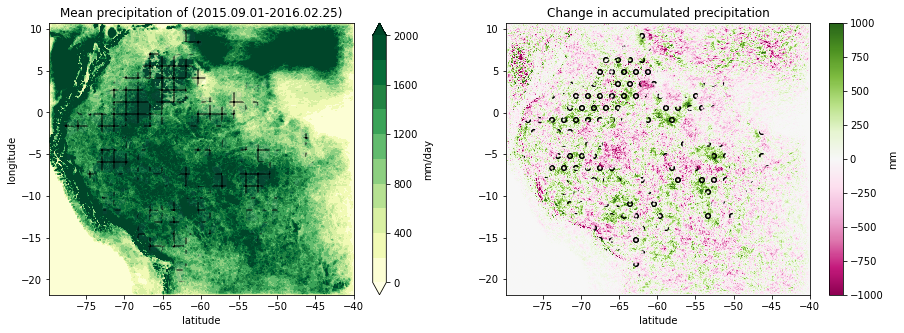

In [84]:
with xarray.open_dataset(path+'Amazon961x801_200509_200602/energyflux_d01_2006-02-28_00:00:00',decode_times=False,
                         mask_and_scale='True') as ds0:
    print('ok')

with xarray.open_dataset(path+'Amazon961x801_200509_200602_ILgrassland/energyflux_d01_2006-02-28_00:00:00',decode_times=False,
                         mask_and_scale='True') as ds1:
    print('ok')
    
fig, axs = plt.subplots(1,2,figsize=(15,5))
im=axs[0].contourf(lons,lats,ds0['RAINNC'][-1,:,:],cmap='YlGn',
               levels=np.arange(0,2001,200),extend='both')
fig.colorbar(im,ax=axs[0],label='mm/day')
axs[0].set_title('Mean precipitation of (2015.09.01-2016.02.25)')
#axs[0].contour(lons,lats,lu1-lu0,levels=[1])
axs[0].contourf(lons,lats,IL_sel,hatches='+',alpha=0.1)

axs[0].set_xlabel('latitude')
axs[0].set_ylabel('longitude')

im=axs[1].pcolormesh(lons,lats,ds1['RAINNC'][-1,:,:]-ds0['RAINNC'][-1,:,:],cmap='PiYG',
              vmin=-1000,vmax=1000 )
fig.colorbar(im,ax=axs[1],label='mm')
axs[1].set_title('Change in accumulated precipitation')
#axs[1].contour(lons,lats,lu1-lu0,levels=[1])
axs[1].contourf(lons,lats,IL_sel,hatches='o',alpha=0.0)
axs[1].set_xlabel('latitude')
#axs[1].set_ylabel('longitude')

### pdf of precipitation change inside and outside of the IL

In [53]:
#### mask the ocean
prec0 = ds0['RAINNC'][-1,:,:]
prec0 = prec0.where(lu0<12,np.nan) # mask the ocean
prec1 = ds1['RAINNC'][-1,:,:]
prec1 = prec1.where(lu1<12,np.nan) # mask the ocean

### find the grids inside and outside of ILs and calculate the area-averaged precip
dif_lu = lu1 - lu0
prec0_IL = prec0.where(dif_lu>0,np.nan) # Inside IL
prec1_IL = prec1.where(dif_lu>0,np.nan) # Inside IL
prec0_out = prec0.where(dif_lu==0,np.nan) # outside IL
prec1_out = prec1.where(dif_lu==0,np.nan) # outside IL

prec0_areaave = prec0.mean(('south_north','west_east'))
prec0_IL_areaave = prec0_IL.mean(('south_north','west_east'))
prec0_out_areaave = prec0_out.mean(('south_north','west_east'))
prec1_areaave = prec1.mean(('south_north','west_east'))
prec1_IL_areaave = prec1_IL.mean(('south_north','west_east'))
prec1_out_areaave = prec1_out.mean(('south_north','west_east'))

Text(0, 0.5, 'Fraction of precipitation')

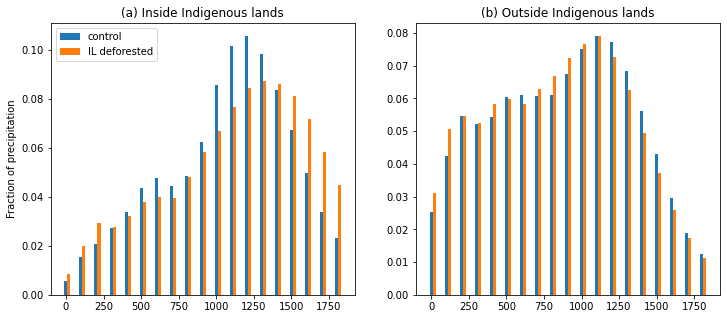

In [54]:
fig, axs = plt.subplots(1,2,figsize=(12,5))

hist0,bins = np.histogram(prec0_IL.values.flatten(),bins=np.arange(0,2000,100))
hist1,bins = np.histogram(prec1_IL.values.flatten(),bins=np.arange(0,2000,100))
axs[0].bar(bins[:-1],hist0/hist0.sum(),width=20,label='control')
axs[0].bar(bins[:-1]+20,hist1/hist1.sum(),width=20, label='IL deforested')

hist0,bins = np.histogram(prec0_out.values.flatten(),bins=np.arange(0,2000,100))
hist1,bins = np.histogram(prec1_out.values.flatten(),bins=np.arange(0,2000,100))
axs[1].bar(bins[:-1],hist0/hist0.sum(),width=20)
axs[1].bar(bins[:-1]+20,hist1/hist1.sum(),width=20)

axs[0].set_title('(a) Inside Indigenous lands')
axs[1].set_title('(b) Outside Indigenous lands')
axs[0].legend()
axs[0].set_ylabel('Fraction of precipitation')

### Fraction of area of precip increase/decrease

In [31]:
dif_prec_IL = prec1_IL - prec0_IL
#np.count_nonzero(dif_prec_IL.values==0)
dif_prec_out = prec1_out - prec0_out
#np.count_nonzero(dif_prec_out.values==0)
#np.sum(np.isnan(prec1_IL.values)==0)

In [35]:
frac1=np.sum(dif_prec_IL>0,axis=1)/np.sum(np.isnan(prec1_IL.values)==0,axis=1)
frac2=np.sum(dif_prec_out>0,axis=1)/np.sum(np.isnan(prec1_out.values)==0,axis=1)
size1 = np.sum(np.isnan(prec1_IL.values)==0,axis=1)
size2 = np.sum(np.isnan(prec1_out.values)==0,axis=1)
size_all = np.sum(np.isnan(prec1.values)==0,axis=1)

Text(0.5, 1.0, 'Fraction of precip increase for accumulated precipitation of 2015.9-2016.2 ')

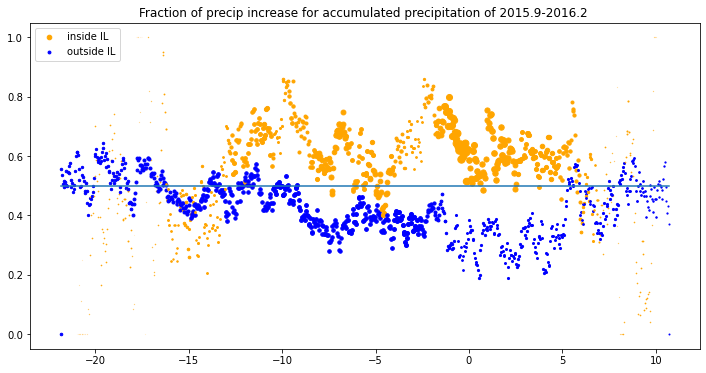

In [38]:
fig, axs = plt.subplots(1,1,figsize=(12,6))
for ii in range(size1.shape[0]):
    plt.scatter(lats[ii],frac1[ii],s=size1[ii]**2/25e2,color='orange')
    plt.scatter(lats[ii],frac2[ii],s=size2[ii]**2/400e2,color='blue')
plt.plot([lats[-1],lats[0]],[0.5,0.5])
ii=500
plt.scatter(lats[ii],frac1[ii],s=size1[ii]**2/25e2,color='orange',label='inside IL')
plt.scatter(lats[ii],frac2[ii],s=size2[ii]**2/400e2,color='blue',label='outside IL')
plt.legend()
plt.title('Fraction of precip increase for accumulated precipitation of 2015.9-2016.2 ')

### Change in zonal mean precipitation. 

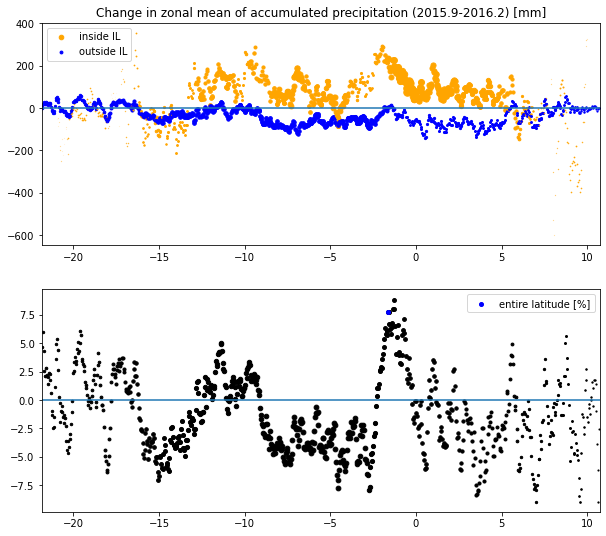

In [40]:
aa = dif_prec_IL.mean('west_east')
bb = dif_prec_out.mean('west_east')
cc = prec1.mean('west_east') - prec0.mean('west_east')
cc = cc/prec0.mean('west_east')*100

fig, axs = plt.subplots(2,1,figsize=(10,9))
for ii in range(size1.shape[0]):
    axs[0].scatter(lats[ii],aa[ii],s=size1[ii]**2/25e2,color='orange')
    axs[0].scatter(lats[ii],bb[ii],s=size2[ii]**2/400e2,color='blue')
    axs[1].scatter(lats[ii],cc[ii],s=size_all[ii]**2/400e2,color='black')

axs[0].set_title('Change in zonal mean of accumulated precipitation (2015.9-2016.2) [mm]')

ii=500
axs[0].scatter(lats[ii],aa[ii],s=size1[ii]**2/25e2,color='orange',label='inside IL')
axs[0].scatter(lats[ii],bb[ii],s=size2[ii]**2/400e2,color='blue',label='outside IL')
axs[1].scatter(lats[ii],cc[ii],s=size_all[ii]**2/400e2,color='blue',label='entire latitude [%]')

for ii in range(2):
    axs[ii].legend()
    axs[ii].plot([lats[0],lats[-1]],[0.,0.])
    #axs[ii].set_ylim([-1,1])
    axs[ii].set_xlim([lats[0],lats[-1]])

## Monthly area-averaged precipitation of [15S-5N] inside and outside of IL

### read data

In [42]:
dates=['2015-09-30','2015-10-31','2015-11-30','2015-12-31','2016-01-31','2016-02-28']
filename = 'energyflux_d01_'+dates[0]+'_00:00:00'
with xarray.open_dataset(path+'Amazon961x801_201509_201602/'+filename,decode_times=False,
                         mask_and_scale='True') as ds0:
    print('ok')
    data0 = ds0['RAINNC'][-1,:,:]

for ii in range(1,6):
    filename = 'energyflux_d01_'+dates[ii]+'_00:00:00'
    with xarray.open_dataset(path+'Amazon961x801_201509_201602/'+filename,decode_times=False,
                         mask_and_scale='True') as ds0:
        tmp=ds0['RAINNC'][-1,:,:]
    data0 = xarray.concat([data0,tmp],dim='month')

### ILgrassland
filename = 'energyflux_d01_'+dates[0]+'_00:00:00'
with xarray.open_dataset(path+'Amazon961x801_201509_201602_ILgrassland/'+filename,decode_times=False,
                         mask_and_scale='True') as ds1:
    print('ok')
    data1 = ds1['RAINNC'][-1,:,:]
for ii in range(1,6):
    filename = 'energyflux_d01_'+dates[ii]+'_00:00:00'
    with xarray.open_dataset(path+'Amazon961x801_201509_201602_ILgrassland/'+filename,decode_times=False,
                         mask_and_scale='True') as ds1:
        tmp=ds1['RAINNC'][-1,:,:]
    data1 = xarray.concat([data1,tmp],dim='month')

## Get the monthly mean precipitation
prec0_mon = xarray.concat([(data0[1:,:,:]-data0[0:-1,:,:])/30,data0[0,:,:]/30],dim='month',coords='different',join='right')
prec1_mon = xarray.concat([(data1[1:,:,:]-data1[0:-1,:,:])/30,data1[0,:,:]/30],dim='month',coords='different',join='right')
prec1_mon = prec1_mon.where(lu1<12,np.nan) # mask the ocean
prec0_mon = prec0_mon.where(lu1<12,np.nan) # mask the ocean

ok
ok


### Line plot of area-mean [15S-5N] change and fraction of precip increase

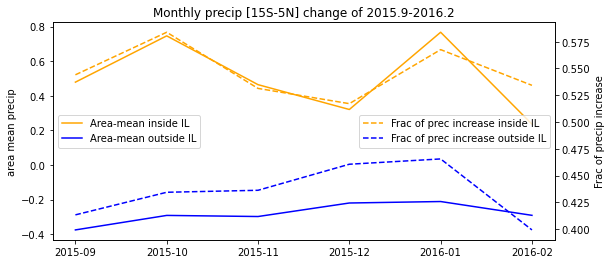

In [43]:
dif_lu = lu1 - lu0
dif_prec_mon = prec1_mon - prec0_mon
dif_prec_mon_IL = dif_prec_mon.where(dif_lu>0,np.nan)
dif_prec_mon_out = dif_prec_mon.where(dif_lu==0,np.nan)
dif_prec_mon_IL_areaave = dif_prec_mon_IL[:,200:700,:].mean(('south_north','west_east'))
dif_prec_mon_out_areaave = dif_prec_mon_out[:,200:700,:].mean(('south_north','west_east'))
frac_IL = np.sum(np.sum(dif_prec_mon_IL[:,200:700,:]>0,axis=2),axis=1)/np.sum(np.sum(np.isnan(dif_prec_mon_IL[0,200:700,:].values)==0,axis=1))
frac_out = np.sum(np.sum(dif_prec_mon_out[:,200:700,:]>0,axis=2),axis=1)/np.sum(np.sum(np.isnan(dif_prec_mon_out[0,200:700,:].values)==0,axis=1))

fig, ax1 = plt.subplots(figsize=(9, 4))
# Instantiate a second axes that shares the same x-axis
ax2 = ax1.twinx()  
ax1.plot(range(6),dif_prec_mon_IL_areaave[:],'orange',label='Area-mean inside IL')
ax1.plot(range(6),dif_prec_mon_out_areaave[:],'blue',label='Area-mean outside IL')
ax2.plot(range(6),frac_IL[:],'orange',linestyle='dashed',label='Frac of prec increase inside IL')
ax2.plot(range(6),frac_out[:],'blue',linestyle='dashed',label='Frac of prec increase outside IL')
ax1.set_ylabel('area mean precip')
ax2.set_ylabel('Frac of precip increase')
ax1.set_xticks(range(6))
ax1.set_xticklabels(['2015-09','2015-10','2015-11','2015-12','2016-01','2016-02'])

plt.title('Monthly precip [15S-5N] change of 2015.9-2016.2')
ax2.legend()
ax1.legend()

### Monthly precip change at each latitude

#### zonal mean precipitation change

<ipython-input-44-60581bc0b880>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im=axes[0].pcolormesh(range(6),lats,np.transpose(dif_prec_mon_IL_areaave.values),cmap='BrBG',vmin=-2,vmax=2)
<ipython-input-44-60581bc0b880>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im=axes[1].pcolormesh(range(6),lats,np.transpose(dif_prec_mon_out_areaave.values),cmap='BrBG',vmin=-2,vmax=2)
<ipython-input-44-60581bc0b880>:9: MatplotlibDeprecationWarning: shading='flat' w

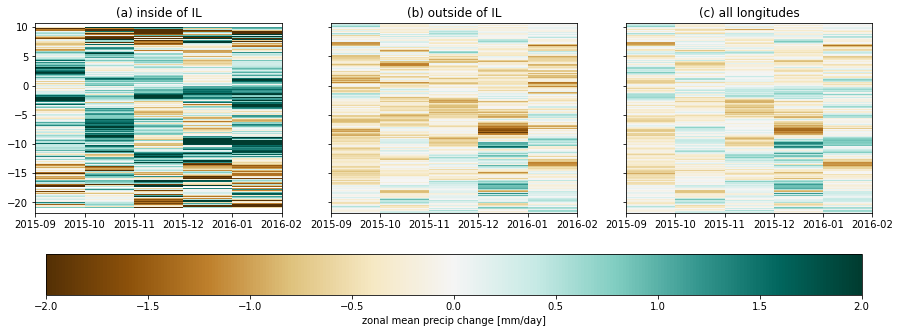

In [44]:
dif_prec_mon_IL_areaave = dif_prec_mon_IL[:,:,:].mean(('west_east'))
dif_prec_mon_out_areaave = dif_prec_mon_out[:,:,:].mean(('west_east'))
dif_prec_mon_areaave = dif_prec_mon[:,:,:].mean(('west_east'))

fig,axes = plt.subplots(1,3,figsize=(15,5),sharex=True,sharey=True)
axes = axes.ravel()  
im=axes[0].pcolormesh(range(6),lats,np.transpose(dif_prec_mon_IL_areaave.values),cmap='BrBG',vmin=-2,vmax=2)
im=axes[1].pcolormesh(range(6),lats,np.transpose(dif_prec_mon_out_areaave.values),cmap='BrBG',vmin=-2,vmax=2)
im=axes[2].pcolormesh(range(6),lats,np.transpose(dif_prec_mon_areaave.values),cmap='BrBG',vmin=-2,vmax=2)

fig.colorbar(im,ax=axes,orientation='horizontal',label='zonal mean precip change [mm/day]')
axes[0].set_title('(a) inside of IL')
axes[1].set_title('(b) outside of IL')
axes[2].set_title('(c) all longitudes')

for ii in range(2):
    axes[ii].set_xticks(range(6))
    axes[ii].set_xticklabels(['2015-09','2015-10','2015-11','2015-12','2016-01','2016-02'])

#### Fraction of precipitation increase

<ipython-input-88-1db399d1692d>:8: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im=axes[0].pcolormesh(range(7),lats,np.transpose(frac_IL.values),cmap='viridis',vmin=0.2,vmax=0.6)
<ipython-input-88-1db399d1692d>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im=axes[1].pcolormesh(range(7),lats,np.transpose(frac_out.values),cmap='viridis',vmin=0.2,vmax=0.6)


Text(0.5, 0.98, 'fraction of precip increase')

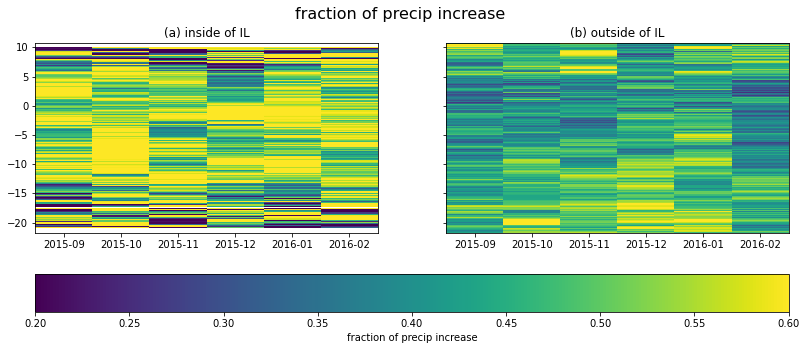

In [88]:
dif_prec_mon_IL_areaave = dif_prec_mon_IL[:,:,:].mean(('west_east'))
dif_prec_mon_out_areaave = dif_prec_mon_out[:,:,:].mean(('west_east'))
frac_IL = np.sum(dif_prec_mon_IL>0,axis=2)/np.sum(np.isnan(dif_prec_mon_IL.values)==0,axis=2)
frac_out = np.sum(dif_prec_mon_out>0,axis=2)/np.sum(np.isnan(dif_prec_mon_out.values)==0,axis=2)

fig,axes = plt.subplots(1,2,figsize=(13.5,5),sharex=True,sharey=True)
axes = axes.ravel()  
im=axes[0].pcolormesh(range(7),lats,np.transpose(frac_IL.values),cmap='viridis',vmin=0.2,vmax=0.6)
im=axes[1].pcolormesh(range(7),lats,np.transpose(frac_out.values),cmap='viridis',vmin=0.2,vmax=0.6)
fig.colorbar(im,ax=axes,orientation='horizontal',label='fraction of precip increase')
axes[0].set_title('(a) inside of IL')
axes[1].set_title('(b) outside of IL')
for ii in range(2):
    axes[ii].set_xticks(np.linspace(0.5,5.5,6))
    axes[ii].set_xticklabels(['2015-09','2015-10','2015-11','2015-12','2016-01','2016-02'])
plt.suptitle('fraction of precip increase',fontsize=16)

### Fraction of prec increase Inside IL for the four quadrants (y_mid = 300; x_mid = 400)


In [85]:
## frac of prec increase Inside IL for the four quadrants (x_mid = 300; y_mid = 539)
dif_prec1=dif_prec_mon_IL[:,539:800,300:960]
dif_prec2=dif_prec_mon_IL[:,539:800,0:300]
dif_prec3=dif_prec_mon_IL[:,0:539,0:300]
dif_prec4=dif_prec_mon_IL[:,0:539,300:960]
frac1 = np.sum(np.sum(dif_prec1>0,axis=2),axis=1)/np.sum(np.sum(np.isnan(dif_prec1.values)==0,axis=2),axis=1)
frac2 = np.sum(np.sum(dif_prec2>0,axis=2),axis=1)/np.sum(np.sum(np.isnan(dif_prec2.values)==0,axis=2),axis=1)
frac3 = np.sum(np.sum(dif_prec3>0,axis=2),axis=1)/np.sum(np.sum(np.isnan(dif_prec3.values)==0,axis=2),axis=1)
frac4 = np.sum(np.sum(dif_prec4>0,axis=2),axis=1)/np.sum(np.sum(np.isnan(dif_prec4.values)==0,axis=2),axis=1)
frac_IL = np.zeros((4,6))
frac_IL[0,:] = frac1
frac_IL[1,:] = frac2
frac_IL[2,:] = frac3
frac_IL[3,:] = frac4

In [86]:
## frac of prec increase outside of IL
dif_prec1=dif_prec_mon_out[:,539:800,300:960]
dif_prec2=dif_prec_mon_out[:,539:800,0:300]
dif_prec3=dif_prec_mon_out[:,0:539,0:300]
dif_prec4=dif_prec_mon_out[:,0:539,300:960]
frac1 = np.sum(np.sum(dif_prec1>0,axis=2),axis=1)/np.sum(np.sum(np.isnan(dif_prec1.values)==0,axis=2),axis=1)
frac2 = np.sum(np.sum(dif_prec2>0,axis=2),axis=1)/np.sum(np.sum(np.isnan(dif_prec2.values)==0,axis=2),axis=1)
frac3 = np.sum(np.sum(dif_prec3>0,axis=2),axis=1)/np.sum(np.sum(np.isnan(dif_prec3.values)==0,axis=2),axis=1)
frac4 = np.sum(np.sum(dif_prec4>0,axis=2),axis=1)/np.sum(np.sum(np.isnan(dif_prec4.values)==0,axis=2),axis=1)
frac_out = np.zeros((4,6))
frac_out[0,:] = frac1
frac_out[1,:] = frac2
frac_out[2,:] = frac3
frac_out[3,:] = frac4

Text(0.5, 0.98, 'fraction of precip increase [%]')

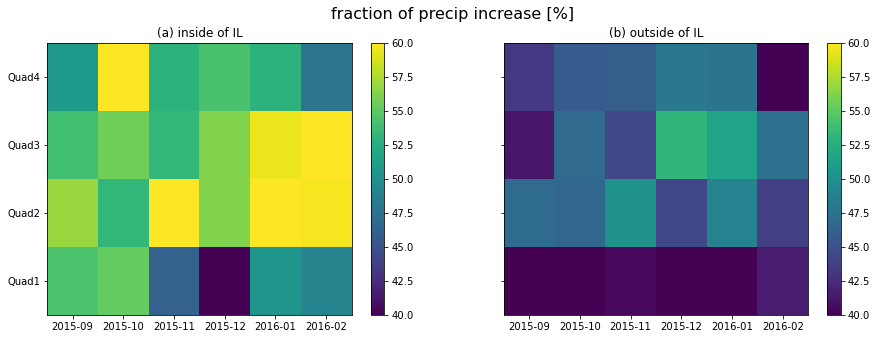

In [87]:
fig,axes = plt.subplots(1,2,figsize=(15,5),sharex=True,sharey=True)
axes = axes.ravel() 
im0=axes[0].pcolormesh(range(7),range(5),frac_IL*100,vmin=40,vmax=60,cmap='viridis')
fig.colorbar(im0,ax=axes[0])
im1=axes[1].pcolormesh(range(7),range(5),frac_out*100,vmin=40,vmax=60,cmap='viridis')
fig.colorbar(im1,ax=axes[1])
axes[0].set_title('(a) inside of IL')
axes[1].set_title('(b) outside of IL')
for ii in range(2):
    axes[ii].set_xticks(np.linspace(0.5,5.5,6))
    axes[ii].set_xticklabels(['2015-09','2015-10','2015-11','2015-12','2016-01','2016-02'])
    axes[ii].set_yticks(np.linspace(0.5,3.5,4))
    axes[ii].set_yticklabels(['Quad1','Quad2','Quad3','Quad4'])
plt.suptitle('fraction of precip increase [%]',fontsize=16)

Text(0.5, 0.98, 'Zonal mean precip change [mm/day]')

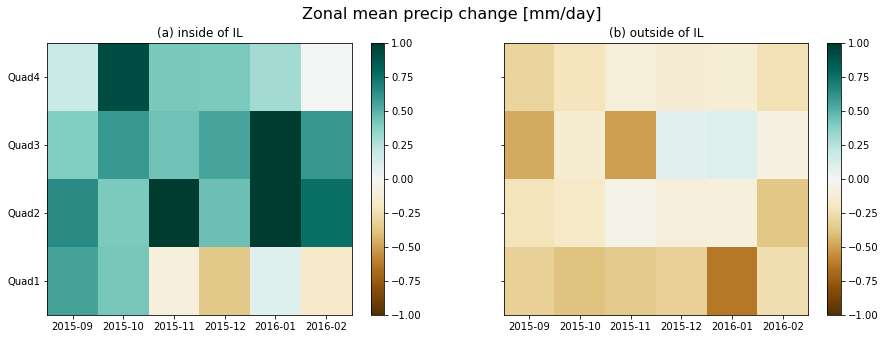

In [83]:
## frac of prec increase Inside IL for the four quadrants (x_mid = 300; y_mid = 400)
dif_prec1=dif_prec_mon_IL[:,539:800,300:960]
dif_prec2=dif_prec_mon_IL[:,539:800,0:300]
dif_prec3=dif_prec_mon_IL[:,0:539,0:300]
dif_prec4=dif_prec_mon_IL[:,0:539,300:960]
frac_IL = np.zeros((4,6))
frac_IL[0,:] = dif_prec1.mean(('south_north','west_east'))
frac_IL[1,:] = dif_prec2.mean(('south_north','west_east'))
frac_IL[2,:] = dif_prec3.mean(('south_north','west_east'))
frac_IL[3,:] = dif_prec4.mean(('south_north','west_east'))

## frac of prec increase outside of IL
dif_prec1=dif_prec_mon_out[:,539:800,300:960]
dif_prec2=dif_prec_mon_out[:,539:800,0:300]
dif_prec3=dif_prec_mon_out[:,0:539,0:300]
dif_prec4=dif_prec_mon_out[:,0:539,300:960]

frac_out = np.zeros((4,6))
frac_out[0,:] = dif_prec1.mean(('south_north','west_east'))
frac_out[1,:] = dif_prec2.mean(('south_north','west_east'))
frac_out[2,:] = dif_prec3.mean(('south_north','west_east'))
frac_out[3,:] = dif_prec4.mean(('south_north','west_east'))

fig,axes = plt.subplots(1,2,figsize=(15,5),sharex=True,sharey=True)
axes = axes.ravel() 
im0=axes[0].pcolormesh(range(7),range(5),frac_IL,vmin=-1,vmax=1,cmap='BrBG')
fig.colorbar(im0,ax=axes[0])
im1=axes[1].pcolormesh(range(7),range(5),frac_out,vmin=-1,vmax=1,cmap='BrBG')
fig.colorbar(im1,ax=axes[1])
axes[0].set_title('(a) inside of IL')
axes[1].set_title('(b) outside of IL')
for ii in range(2):
    axes[ii].set_xticks(np.linspace(0.5,5.5,6))
    axes[ii].set_xticklabels(['2015-09','2015-10','2015-11','2015-12','2016-01','2016-02'])
    axes[ii].set_yticks(np.linspace(0.5,3.5,4))
    axes[ii].set_yticklabels(['Quad1','Quad2','Quad3','Quad4'])
plt.suptitle('Zonal mean precip change [mm/day]',fontsize=16)

## Load the precipitation data (accumulated gridscale rainfall in hourly resolution)

In [ ]:
import xarray
path = '/ocean/projects/ees210014p/xjliu/Amazon_exp/'
with xarray.open_dataset(path+'post_processing/Amazon961x801/precip.ctrl.201509_201602.nc',decode_times=False,
                         mask_and_scale='True') as ds0:
    print('ok')
#prec0 = ds0['RAINNC'][1:,:,:] - ds0['RAINNC'][0:-1,:,:]

with xarray.open_dataset(path+'post_processing/Amazon961x801/precip.ILgrassland.201509_201602.nc',decode_times=False,
                         mask_and_scale='True') as ds1:
    print('ok')
#prec1 = ds1['RAINNC'][1:,:,:] - ds1['RAINNC'][0:-1,:,:]
prec1_day = ds1['RAINNC'][23::24,:,:]
prec0_day = ds0['RAINNC'][23::24,:,:]

ok
ok


In [ ]:
# Another way of calculating daily accumulated precipitation
prec1_day_test = ds1['RAINNC'][24::24,:,:]

np.sum(prec1_day_test[:,:,:]-prec1_day[:,:,:])

<xarray.DataArray 'RAINNC' ()>
array(5.18035983e+10)

In [ ]:
prec1_day.shape

(181, 800, 960)

## Check the daily mean and monthly mean precipitation

In [ ]:
# change precipitaiton to mm/day
import copy
#prec0_day = np.zeros(prec0[:180,:,:].shape)
#prec1_day = np.zeros(prec0[:180,:,:].shape)

#for ii in range(180):
#    prec0_day[ii,:,:] = prec0[ii*24:(ii+1)*24,:,:].sum(axis=0)
#    prec1_day[ii,:,:] = prec1[ii*24:(ii+1)*24,:,:].sum(axis=0)

prec0_mon = np.zeros(prec0[:6,:,:].shape)
prec1_mon = np.zeros(prec0[:6,:,:].shape)
for ii in range(6):
    prec0_mon[ii,:,:] = prec0_day[ii*30:(ii+1)*30,:,:].mean(axis=0)
    prec1_mon[ii,:,:] = prec1_day[ii*30:(ii+1)*30,:,:].mean(axis=0)

<ipython-input-16-b0f0abc70910>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = axes[ii].pcolormesh(lons,lats,prec0_day[ii*30,:,:],


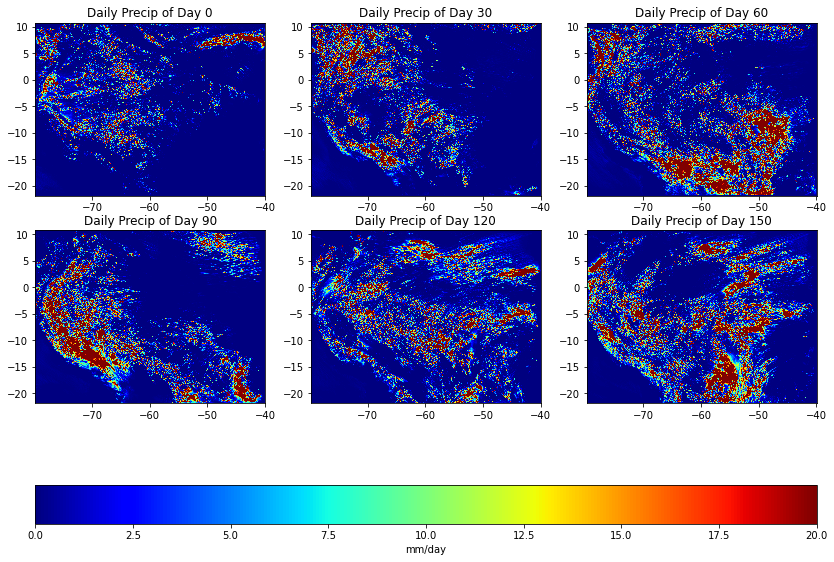

In [ ]:
fig, axes = plt.subplots(2,3,figsize=(14,10))
axes = axes.ravel()
months = ['Sept','Oct','Nov','Dec','Jan','Feb']
for ii in range(6):
    im = axes[ii].pcolormesh(lons,lats,prec0_day[ii*30,:,:],
                       vmin=0,vmax=20,cmap='jet')
    axes[ii].set_title('Daily Precip of Day '+str(ii*30))

fig.colorbar(im, ax=axes,label='mm/day',orientation='horizontal')


<ipython-input-17-83a0b4ac78bd>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = axes[ii].pcolormesh(lons,lats,prec0_day[ii*30:ii*30+30,:,:].mean(axis=0),


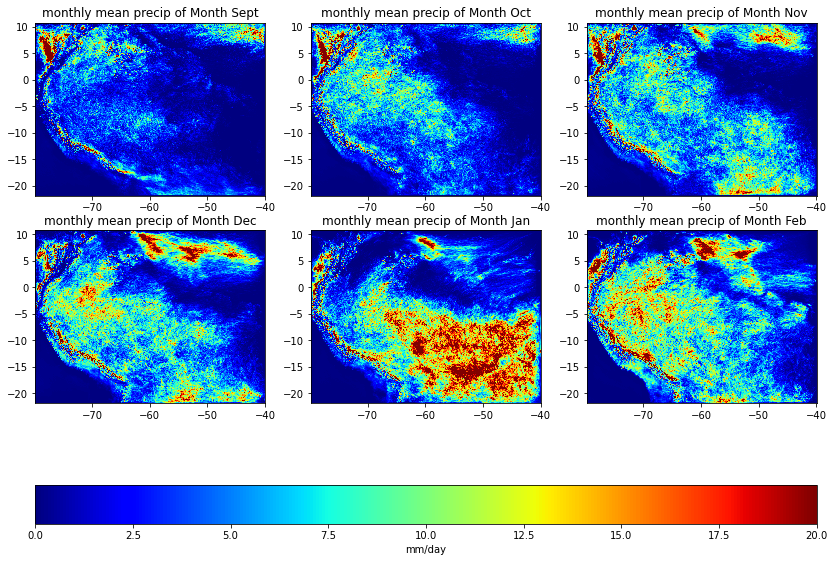

In [ ]:
fig, axes = plt.subplots(2,3,figsize=(14,10))
axes = axes.ravel()
months = ['Sept','Oct','Nov','Dec','Jan','Feb']
for ii in range(6):
    im = axes[ii].pcolormesh(lons,lats,prec0_day[ii*30:ii*30+30,:,:].mean(axis=0),
                       vmin=0,vmax=20,cmap='jet')
    axes[ii].set_title('monthly mean precip of Month '+months[ii])

fig.colorbar(im, ax=axes,label='mm/day',orientation='horizontal')

## Change in monthly mean precipitation

<ipython-input-18-ebd1a4cdabe7>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = axes[3*ii].pcolormesh(lons,lats,prec0_mon[ii,:,:],
<ipython-input-18-ebd1a4cdabe7>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = axes[3*ii+1].pcolormesh(lons,lats,prec1_mon[ii,:,:],
<ipython-input-18-ebd1a4cdabe7>:9: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the qua

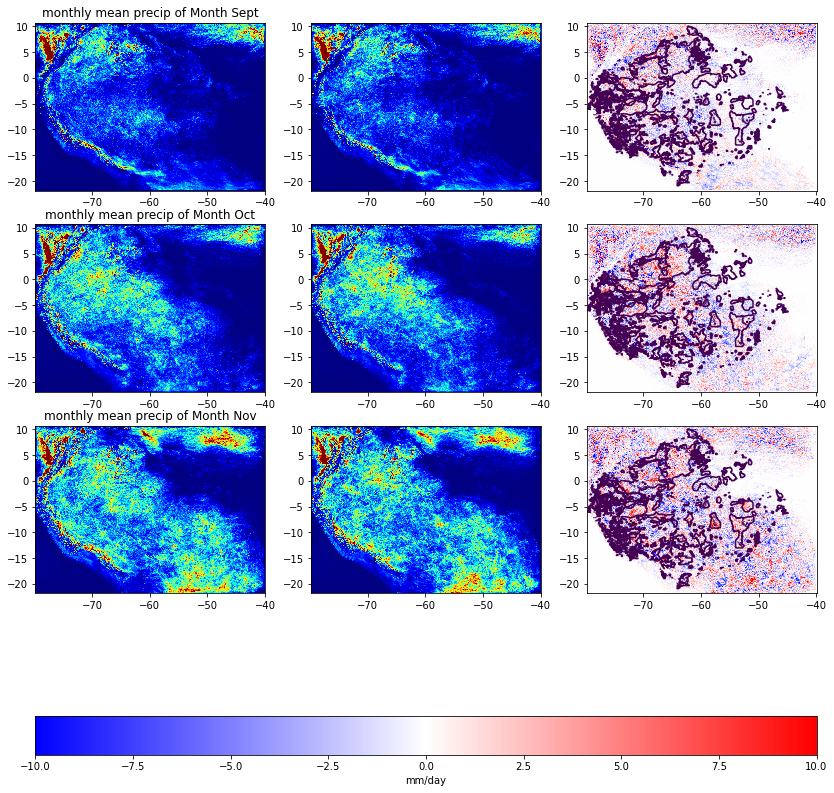

In [ ]:
fig, axes = plt.subplots(3,3,figsize=(14,15))
axes = axes.ravel()
months = ['Sept','Oct','Nov','Dec','Jan','Feb']
for ii in range(3):
    im = axes[3*ii].pcolormesh(lons,lats,prec0_mon[ii,:,:],
                       vmin=0,vmax=20,cmap='jet')
    im = axes[3*ii+1].pcolormesh(lons,lats,prec1_mon[ii,:,:],
                       vmin=0,vmax=20,cmap='jet')
    im = axes[3*ii+2].pcolormesh(lons,lats,prec1_mon[ii,:,:] - prec0_mon[ii,:,:],
                       vmin=-10,vmax=10,cmap='bwr')
    axes[3*ii+2].contour(lons,lats,lu1-lu0,levels=[1])
    axes[3*ii].set_title('monthly mean precip of Month '+months[ii])

fig.colorbar(im, ax=axes,label='mm/day',orientation='horizontal')

## Calculation of MCWD
### accumulation of precip - ET (set it to be constant here 3.3 mm/day) greater than 0

In [34]:
cwd0 = np.zeros(prec0_day.shape)
cwd1 = np.zeros(prec0_day.shape)

#prec0_day[]
for ii in range(1,180):
    cwd0[ii,:,:] = cwd0[ii-1,:,:] + prec0_day[ii,:,:] - 3
    cwd0[ii,:,:]= np.where(cwd0[ii,:,:]>0,0,cwd0[ii,:,:])   
    
    cwd1[ii,:,:] = cwd1[ii-1,:,:] + prec1_day[ii,:,:] - 3
    cwd1[ii,:,:]= np.where(cwd1[ii,:,:]>0,0,cwd1[ii,:,:])   

<ipython-input-35-374b039d52bf>:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im0 = axes[0].pcolormesh(lons,lats,cwd0[TIME,:,:],cmap='jet')
<ipython-input-35-374b039d52bf>:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im1 = axes[1].pcolormesh(lons,lats,cwd1[TIME,:,:],cmap='jet')
<ipython-input-35-374b039d52bf>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners 

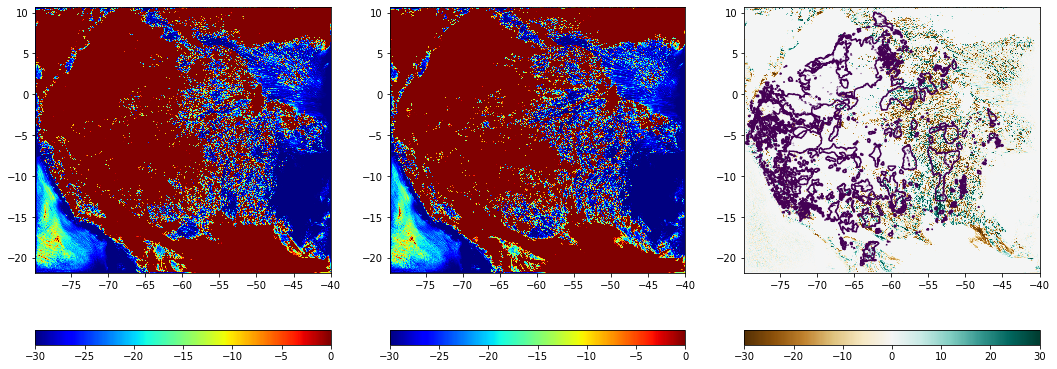

In [35]:
fig, axes = plt.subplots(1,3,figsize=(18,7))
axes = axes.ravel()

TIME=10
im0 = axes[0].pcolormesh(lons,lats,cwd0[TIME,:,:],cmap='jet')
im1 = axes[1].pcolormesh(lons,lats,cwd1[TIME,:,:],cmap='jet')
im2=axes[2].pcolormesh(lons,lats,cwd1[TIME,:,:]-cwd0[TIME,:,:],cmap='BrBG')
axes[2].contour(lons,lats,lu1-lu0,levels=[1])
fig.colorbar(im0,ax=axes[0],orientation='horizontal')
fig.colorbar(im1,ax=axes[1],orientation='horizontal')
fig.colorbar(im2,ax=axes[2],orientation='horizontal')

<ipython-input-40-423358ba7d4a>:2: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  plt.pcolormesh(lons,lats,cwd1[TIME,:,:]-cwd0[TIME,:,:],cmap='BrBG')


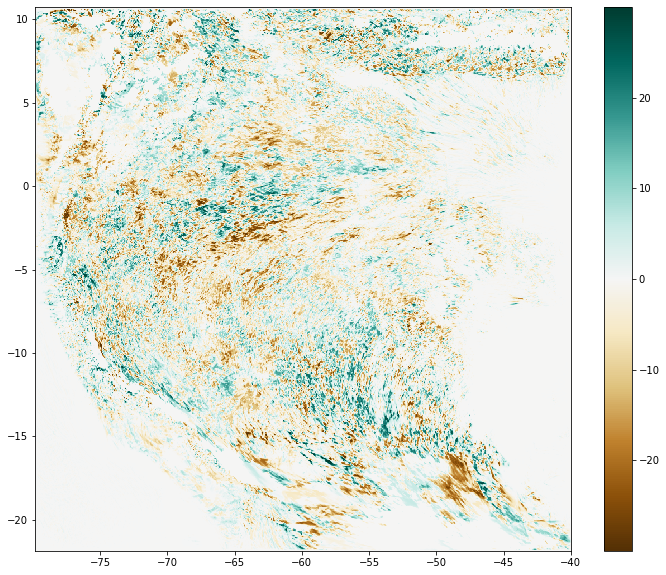

In [40]:
plt.figure(figsize=(12,10))
plt.pcolormesh(lons,lats,cwd1[TIME,:,:]-cwd0[TIME,:,:],cmap='BrBG')
#plt.contour(lons,lats,lu0,levels=[2,12])
plt.colorbar()

In [ ]:
path = '/ocean/projects/ees210014p/xjliu/Amazon_exp/'
with xarray.open_dataset(path+'post_processing/Amazon561x721/energy.2015.01.UTC15.mean.ctrl.nc',decode_times=False,
                         mask_and_scale='True') as ds0:
    print('ok')

with xarray.open_dataset(path+'post_processing/Amazon561x721/energy.2015.01.UTC15.mean.ILgrassland.nc',decode_times=False,
                         mask_and_scale='True') as ds1:
    print('ok')

fig,axes = plt.subplots(2,2,figsize=(12,10),sharex=True,sharey=True)
axes = axes.ravel()  
varname = ['LH','HFX','TSK','ALBEDO']

vmins=[-200,-50,-5,-0.1]
vmaxs=[200,50,5,0.1]
cmaps=['PiYG','PiYG','bwr','coolwarm','bwr','PiYG']
units=['W/m^2','W/m^2','K','1']

for ii in range(4):
    img = axes[ii].pcolormesh(lons,lats,ds1[varname[ii]][0,:,:]-ds0[varname[ii]][0,:,:],cmap='bwr',
                            vmin=vmins[ii],vmax=vmaxs[ii])
    fig.colorbar(img,ax=axes[ii],orientation='vertical',label='units: '+units[ii])
    axes[ii].set_title(varname[ii])
    axes[ii].contour(lons,lats,lu1-lu0,levels=[1])


# Energy budget at the surface

## 1. change in ground flux (net radiation - LH - SH) is not small

<ipython-input-13-697766716c61>:14: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = axes[0].pcolormesh(lons,lats,Rad1[0,:,:],cmap='jet',vmin=0,vmax=1000)
<ipython-input-13-697766716c61>:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = axes[1].pcolormesh(lons,lats,Rnet1[0,:,:],cmap='jet',vmin=0,vmax=1000)
<ipython-input-13-697766716c61>:20: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3

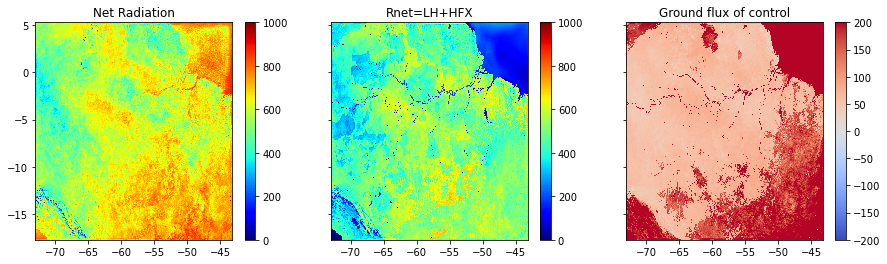

In [13]:
Rad0 = ds0['SWDNB']-ds0['SWUPB']+ds0['LWDNB']-ds0['LWUPB']
Rad1 = ds1['SWDNB']-ds1['SWUPB']+ds1['LWDNB']-ds1['LWUPB']
Rnet0 = ds0['HFX']+ds0['LH']
Rnet1 = ds1['HFX']+ds1['LH']

Rsoil0 = Rad0 - Rnet0
Rsoil1 = Rad1 - Rnet1

var='SWUPB'

fig,axes = plt.subplots(1,3,figsize=(15,4),sharex=True,sharey=True)
axes = axes.ravel()  

im = axes[0].pcolormesh(lons,lats,Rad1[0,:,:],cmap='jet',vmin=0,vmax=1000)
fig.colorbar(im,ax=axes[0])

im = axes[1].pcolormesh(lons,lats,Rnet1[0,:,:],cmap='jet',vmin=0,vmax=1000)
fig.colorbar(im,ax=axes[1])

im = axes[2].pcolormesh(lons,lats,Rad0[0,:,:]-Rnet0[0,:,:],cmap='coolwarm',vmin=-200,vmax=200)
fig.colorbar(im,ax=axes[2])

titles=['Net Radiation','Rnet=LH+HFX','Ground flux of control']
for ii in range(3):
    axes[ii].set_title(titles[ii])

## 2. Change in energy at the surface

<ipython-input-14-f162ddf55039>:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = axes[0].pcolormesh(lons,lats,Rad1[0,:,:]-Rad0[0,:,:],cmap='bwr',vmin=-200,vmax=200)
<ipython-input-14-f162ddf55039>:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = axes[1].pcolormesh(lons,lats,Rnet1[0,:,:]-Rnet0[0,:,:],cmap='bwr',vmin=-200,vmax=200)
<ipython-input-14-f162ddf55039>:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions a

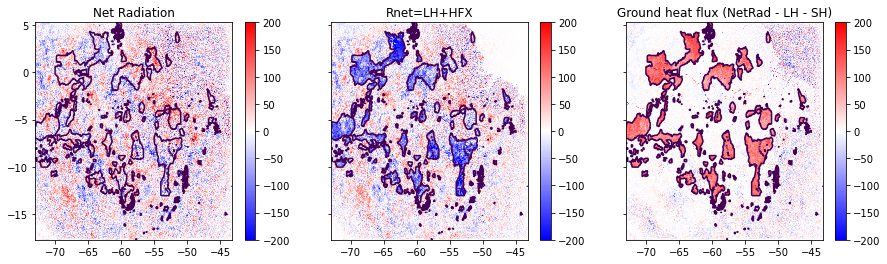

In [14]:
fig,axes = plt.subplots(1,3,figsize=(15,4),sharex=True,sharey=True)
axes = axes.ravel()  

im = axes[0].pcolormesh(lons,lats,Rad1[0,:,:]-Rad0[0,:,:],cmap='bwr',vmin=-200,vmax=200)
fig.colorbar(im,ax=axes[0])

im = axes[1].pcolormesh(lons,lats,Rnet1[0,:,:]-Rnet0[0,:,:],cmap='bwr',vmin=-200,vmax=200)
fig.colorbar(im,ax=axes[1])

im = axes[2].pcolormesh(lons,lats,Rsoil1[0,:,:]-Rsoil0[0,:,:],cmap='bwr',vmin=-200,vmax=200)
fig.colorbar(im,ax=axes[2])

titles=['Net Radiation','Rnet=LH+HFX','Ground heat flux (NetRad - LH - SH)']
for ii in range(3):
    axes[ii].set_title(titles[ii])
    axes[ii].contour(lons,lats,lu1-lu0,levels=[1])

## 3. Change in each energy term at the surface

<ipython-input-15-9db777f47c5b>:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = axes[ii].pcolormesh(lons,lats,ds1[varxs[ii]][0,:,:] - ds0[varxs[ii]][0,:,:],
<ipython-input-15-9db777f47c5b>:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = axes[ii].pcolormesh(lons,lats,ds1[varxs[ii]][0,:,:] - ds0[varxs[ii]][0,:,:],
<ipython-input-15-9db777f47c5b>:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is depreca

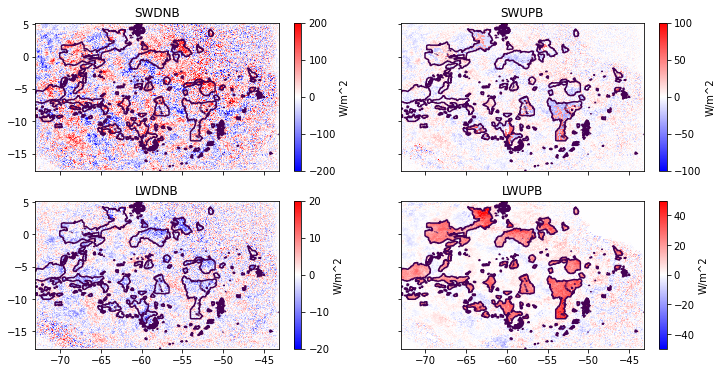

In [15]:
varxs=['SWDNB','SWUPB','LWDNB','LWUPB']#'SWUPT','LWUPT','LWDNB','LWUPB','LWDNT',

fig,axes = plt.subplots(2,2,figsize=(12,6),sharex=True,sharey=True)
axes = axes.ravel()  

vmins = [-200,-100,-20,-50]
vmaxs = [200,100,20,50]

for ii in range(4):
    im = axes[ii].pcolormesh(lons,lats,ds1[varxs[ii]][0,:,:] - ds0[varxs[ii]][0,:,:],
                             cmap='bwr',vmin=vmins[ii],vmax=vmaxs[ii])
    axes[ii].contour(lons,lats,lu1-lu0,levels=[1])
    axes[ii].set_title(varxs[ii])
    fig.colorbar(im,ax=axes[ii],orientation='vertical',label='W/m^2')


## Plot the winds

<ipython-input-22-6e6bd5d53a48>:7: UserWarning: The following kwargs were not used by contour: 'scale_units'
  plt.contour(lons,lats,lu1-lu0,levels=[1],scale_units='inches')


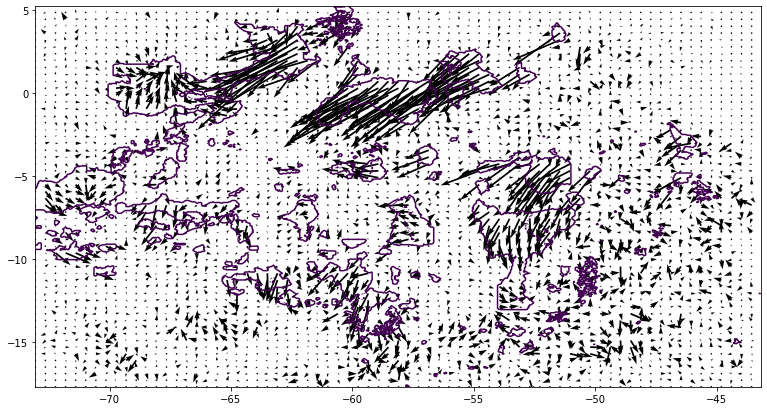

In [22]:
plt.figure(figsize=(13,7))
u10 = ds1['U10']-ds0['U10']
v10 = ds1['V10']-ds0['V10']
plt.quiver(lons[::10], lats[::10],
           u10[0,::10, ::10], v10[0,::10, ::10],
           cmap='jet')
plt.contour(lons,lats,lu1-lu0,levels=[1],scale_units='inches')


## 4. Relate 3 to clouds, surface temperature, and surface humidity etc. 

## Soil moisture

In [9]:
with xarray.open_dataset(path+'SMOIS.201409_201412.ILave.ctrl.nc',decode_times=False,
                         mask_and_scale='True') as ds0:
    print('ok')
    
with xarray.open_dataset(path+'SMOIS.201409_201412.ILave.ILgrassland.nc',decode_times=False,
                         mask_and_scale='True') as ds1:
    print('ok')
    
smois0_areaave = ds0['SMOIS']
smois1_areaave = ds1['SMOIS']

ok
ok


Text(0, 0.5, 'Soil Moisture [m3/m3]')

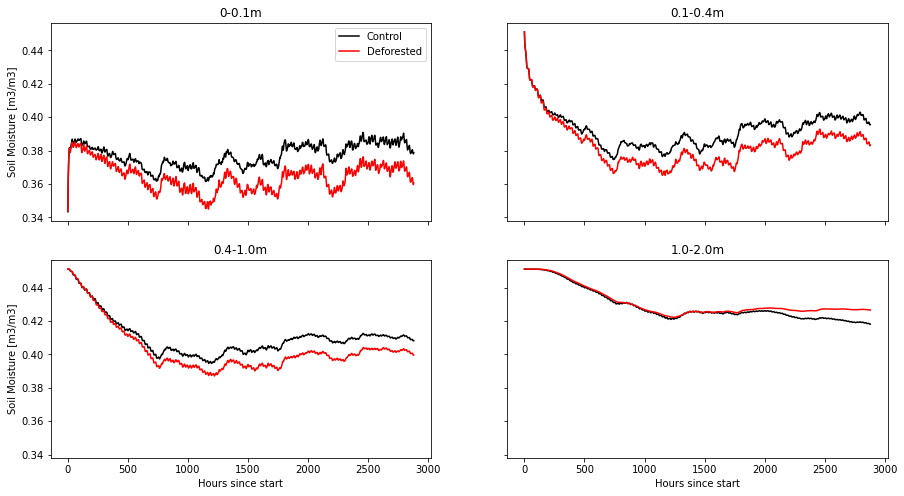

In [11]:
fig,axes = plt.subplots(2,2,figsize=(15,8),sharex=True,sharey=True)
axes = axes.ravel()  
titles=['0-0.1m','0.1-0.4m','0.4-1.0m','1.0-2.0m']
for ii in range(4):
    axes[ii].plot(smois0_areaave[:,ii],'k',label='Control')
    axes[ii].plot(smois1_areaave[:,ii],'r',label='Deforested')
    axes[ii].set_title(titles[ii])
axes[0].legend()
axes[2].set_xlabel('Hours since start')
axes[3].set_xlabel('Hours since start')
axes[0].set_ylabel('Soil Moisture [m3/m3]')
axes[2].set_ylabel('Soil Moisture [m3/m3]')

### Soil moisture

ok


<ipython-input-83-b578299b01ef>:13: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  img = axes[ii].pcolormesh(lons,lats,ds1['SMOIS'][600+ii*5,0,:,:],cmap='coolwarm',vmin=-0.1,vmax=0.1


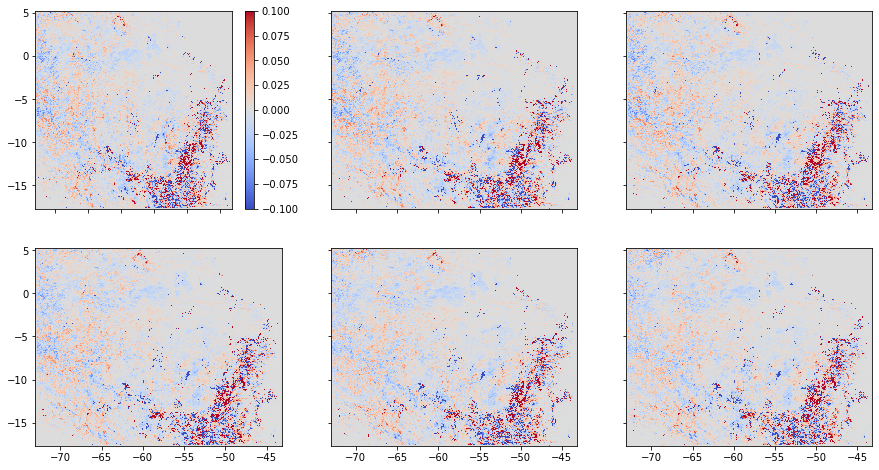

In [83]:
path = '/ocean/projects/ees210014p/xjliu/Amazon_exp/'

with xarray.open_dataset(path+'Amazon_NoahMP_dveg9_201407_ILgrassland/dif_LAND.nc',decode_times=False,
                         mask_and_scale='True') as ds1:
    print('ok')
    
fig,axes = plt.subplots(2,3,figsize=(15,8),sharex=True,sharey=True)
axes = axes.ravel()  
varname = ['SMOIS']


for ii in range(6):
    img = axes[ii].pcolormesh(lons,lats,ds1['SMOIS'][600+ii*5,0,:,:],cmap='coolwarm',vmin=-0.1,vmax=0.1
                         )
fig.colorbar(img,ax=axes[0])
#axes[ii].contour(lons,lats,lu1,levels=[5])

In [ ]:
### TSK for both noon and night
fig,axes = plt.subplots(1,2,figsize=(14,4),sharex=True,sharey=True)
axes = axes.ravel()  
img = axes[0].contourf(lons,lats,ds0['TSK'].mean('Time')-273.15,cmap='rainbow',
                             levels=np.arange(20,51,1),extend='both')
fig.colorbar(img,ax=axes[0])
axes[0].set_title('TSK at local noon')
### local night
img = axes[1].contourf(lons,lats,ds1['TSK'].mean('Time')-273.15,cmap='rainbow',
                             levels=np.arange(20,31,1),extend='both')
fig.colorbar(img,ax=axes[1])
axes[ii].set_title('TSK at local night')

ok


Text(0.5, 1.0, 'TSK at local night')

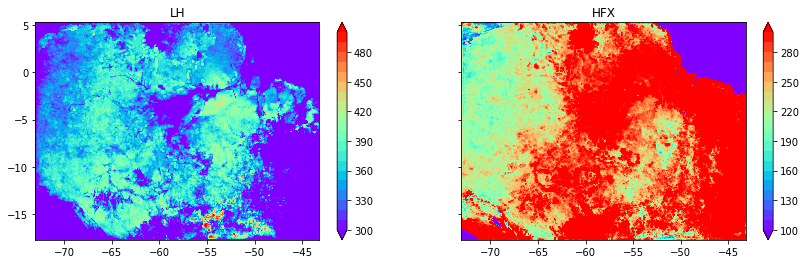

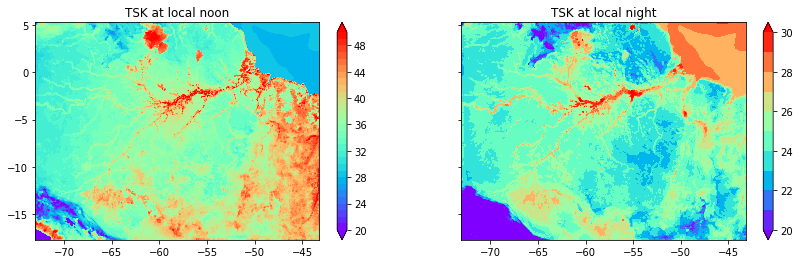

In [17]:
### Default NOAH_MP
with xarray.open_dataset(path+'post_processing/Amazon561x721/energy.2015.obs.NoahMP.multidaymean.nc',decode_times=False,
                         mask_and_scale='True') as ds0:
    print('ok')
    
fig,axes = plt.subplots(1,2,figsize=(14,4),sharex=True,sharey=True)
axes = axes.ravel()  
varname = ['LH','HFX','TSK','ALBEDO']
levs=[np.arange(300,501,10),np.arange(100,301,10),np.arange(20,51,1)]

for ii in range(2):
    img = axes[ii].contourf(lons,lats,ds0[varname[ii]][15,:,:],cmap='rainbow',
                             levels=levs[ii],extend='both')
    fig.colorbar(img,ax=axes[ii])
    axes[ii].set_title(varname[ii])
    #axes[ii].contour(lons,lats,lu1,levels=[5])

### TSK for both noon and night
fig,axes = plt.subplots(1,2,figsize=(14,4),sharex=True,sharey=True)
axes = axes.ravel()  
img = axes[0].contourf(lons,lats,ds0['TSK'][15,:,:]-273.15,cmap='rainbow',
                             levels=np.arange(20,51,1),extend='both')
fig.colorbar(img,ax=axes[0])
axes[0].set_title('TSK at local noon')
### local night
img = axes[1].contourf(lons,lats,ds0['TSK'][5,:,:]-273.15,cmap='rainbow',
                             levels=np.arange(20,31,1),extend='both')
fig.colorbar(img,ax=axes[1])
axes[ii].set_title('TSK at local night')    

ok


Text(0.5, 1.0, 'TSK at local night')

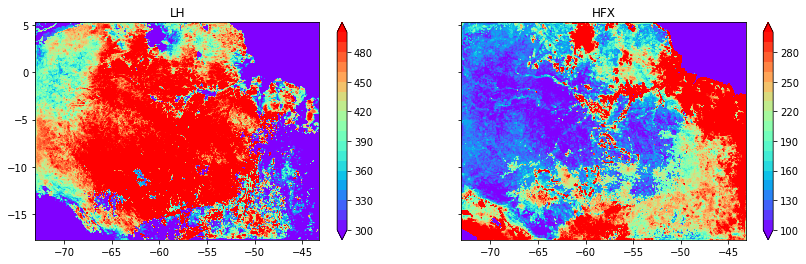

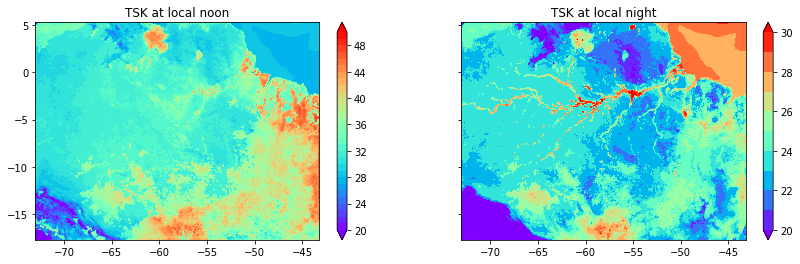

In [18]:
#### CLM4 
with xarray.open_dataset(path+'post_processing/Amazon561x721/energy.201511.obs.nc',decode_times=False,
                         mask_and_scale='True') as ds0:
    print('ok')
    
fig,axes = plt.subplots(1,2,figsize=(14,4),sharex=True,sharey=True)
axes = axes.ravel()  
varname = ['LH','HFX','TSK','ALBEDO']
levs=[np.arange(300,501,10),np.arange(100,301,10),np.arange(20,51,1)]

for ii in range(2):
    img = axes[ii].contourf(lons,lats,ds0[varname[ii]][15,:,:],cmap='rainbow',
                             levels=levs[ii],extend='both')
    fig.colorbar(img,ax=axes[ii])
    axes[ii].set_title(varname[ii])
    #axes[ii].contour(lons,lats,lu1,levels=[5])

### TSK for both noon and night
fig,axes = plt.subplots(1,2,figsize=(14,4),sharex=True,sharey=True)
axes = axes.ravel()  
img = axes[0].contourf(lons,lats,ds0['TSK'][15,:,:]-273.15,cmap='rainbow',
                             levels=np.arange(20,51,1),extend='both')
fig.colorbar(img,ax=axes[0])
axes[0].set_title('TSK at local noon')
### local night
img = axes[1].contourf(lons,lats,ds0['TSK'][5,:,:]-273.15,cmap='rainbow',
                             levels=np.arange(20,31,1),extend='both')
fig.colorbar(img,ax=axes[1])
axes[ii].set_title('TSK at local night')    

ok
ok


<ipython-input-6-2c93235d98cf>:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  img = axes[ii].pcolormesh(lons,lats,ds1[varname[ii]].mean('Time')-ds0[varname[ii]].mean('Time'),cmap='bwr',
<ipython-input-6-2c93235d98cf>:21: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  img = axes[ii].pcolormesh(lons,lats,ds1[varname[ii]].mean('Time')-ds0[varname[ii]].mean('Time'),cmap='bwr',
<ipython-input-6-2c93235d98cf>:21: MatplotlibDeprecationWarning: shading='flat' when

Text(0.5, 0.98, 'Local Noon dif. of (ILdeforested - Control); Average of 2015.11.14-2015.11.30')

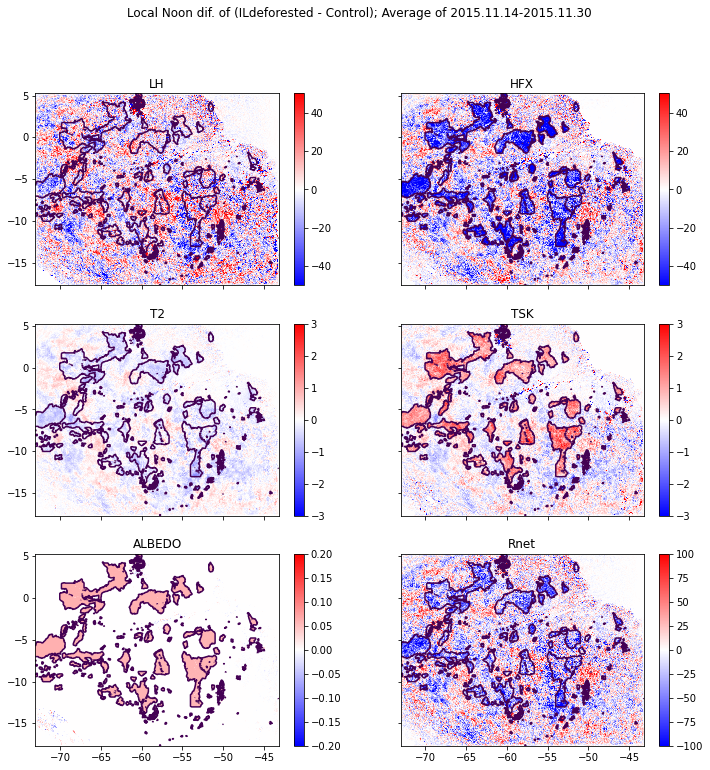

In [6]:
path = '/ocean/projects/ees210014p/xjliu/Amazon_exp/'
#with xarray.open_dataset(path+'Amazon/energyflux_d01_2015-11-01_15:00:00',decode_times=False,
with xarray.open_dataset(path+'Amazon_NoahMP_dveg9/energyflux_d01_201511_15UTC.obs.multidaymean.nc',decode_times=False,
                         mask_and_scale='True') as ds0:
    print('ok')

#with xarray.open_dataset(path+'post_processing/Amazon561x721/energy.201511.obs.nc',decode_times=False,
 #                        mask_and_scale='True') as ds0:
with xarray.open_dataset(path+'Amazon_NoahMP_dveg9_ILgrassland/energyflux_d01_201511_15UTC.ILgrassland.multidaymean.nc',decode_times=False,
                         mask_and_scale='True') as ds1:
                         print('ok')
    
fig,axes = plt.subplots(3,2,figsize=(12,12),sharex=True,sharey=True)
axes = axes.ravel()  
varname = ['LH','HFX','T2','TSK','ALBEDO']

vmins=[-50,-50,-3,-3,-0.2,-100]
vmaxs=[50,50,3,3,0.2,100]
cmaps=['PiYG','PiYG','bwr','coolwarm','bwr','PiYG']
for ii in range(5):
    img = axes[ii].pcolormesh(lons,lats,ds1[varname[ii]].mean('Time')-ds0[varname[ii]].mean('Time'),cmap='bwr',
                             vmin=vmins[ii],vmax=vmaxs[ii])
    fig.colorbar(img,ax=axes[ii])
    axes[ii].set_title(varname[ii])
    axes[ii].contour(lons,lats,lu1-lu0,levels=[1,10])
    
## plot Rnet
Rnet0 = ds0['LH'] + ds0['HFX']
Rnet1 = ds1['LH'] + ds1['HFX']

img = axes[5].pcolormesh(lons,lats,Rnet1.mean('Time')-Rnet0.mean('Time'),vmin=vmins[5],vmax=vmaxs[5],
                       cmap='bwr')

fig.colorbar(img,ax=axes[5])
axes[5].set_title('Rnet')
axes[5].contour(lons,lats,lu1-lu0,levels=[1,10])    

plt.suptitle('Local Noon dif. of (ILdeforested - Control); Average of 2015.11.14-2015.11.30')

## Diurnal cycle

In [53]:
dif = ds1[varname[ii]] - ds0[varname[ii]]
dif_lu = lu1-lu0
dif_forests = dif.where(dif_lu>0)
diurnal_north = dif_forests[:,380:,200:600].mean(('south_north','west_east'))
diurnal_west = dif_forests[0,100:,:200].mean(('south_north','west_east'))
#plt.contourf(dif_forests)


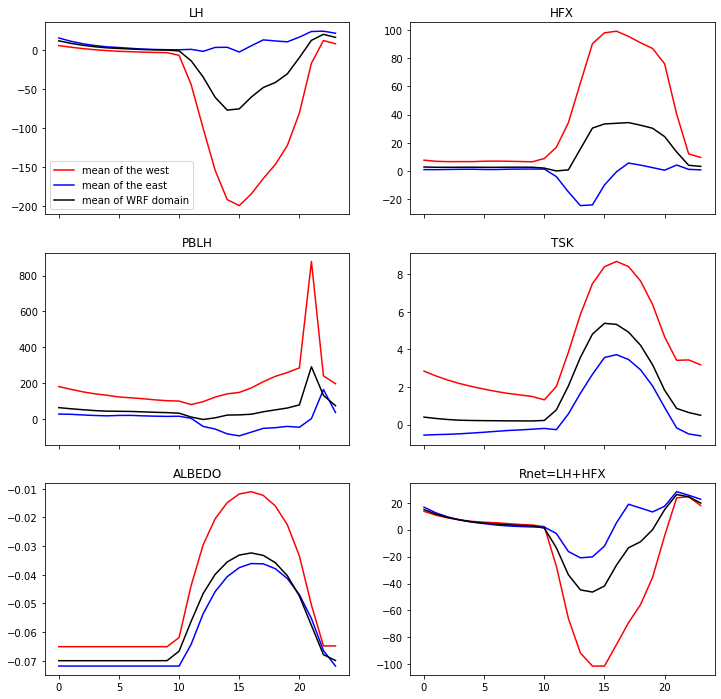

In [70]:
fig,axes = plt.subplots(3,2,figsize=(12,12),sharex=True)
axes = axes.ravel()  
varname = ['LH','HFX','PBLH','TSK','ALBEDO','Rnet=LH+HFX']
for ii in range(5):
    dif = ds1[varname[ii]] - ds0[varname[ii]]
    dif_lu = lu1-lu0
    dif_forests = dif.where(dif_lu>0)
    diurnal_north = dif_forests[:,380:,200:600].mean(('south_north','west_east'))
    diurnal_west = dif_forests[:,100:,:200].mean(('south_north','west_east'))
    diurnal_all = dif_forests.mean(('south_north','west_east'))

    
    axes[ii].plot(range(24),diurnal_north,'-r',label='mean of the west')
    axes[ii].plot(range(24),diurnal_west,'-b',label='mean of the east')
    axes[ii].plot(range(24),diurnal_all,'-k',label='mean of WRF domain')

    axes[ii].set_title(varname[ii])
    
axes[0].legend()
   
## plot Rnet
dif_Rnet = ds1['LH'] + ds1['HFX'] - (ds0['LH'] + ds0['HFX'])
dif_forests = dif_Rnet.where(dif_lu>0)
diurnal_north = dif_forests[:,380:,200:600].mean(('south_north','west_east'))
diurnal_west = dif_forests[:,100:,:200].mean(('south_north','west_east'))
diurnal_all = dif_forests.mean(('south_north','west_east'))
axes[5].plot(range(24),diurnal_north,'-r')
axes[5].plot(range(24),diurnal_west,'-b')
axes[5].plot(range(24),diurnal_all,'-k')
axes[5].set_title(varname[5])

